In [1]:
import os
import re
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats
from rasterio.warp import calculate_default_transform, reproject, Resampling
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
os.environ['OMP_NUM_THREADS'] = '2'

### Inputs

In [3]:
# General inputs
geodata= pd.read_csv('../../model/model_versions/v_7/v7_1/hds_model/GeoData.txt', sep= '\t', index_col=0)

st_mary= pd.read_csv('../../geospacial/misc/stmary_seg', header= None)

milk_shapefile= gpd.read_file('../../geospacial/shapefiles/milk_shapefile/Milk_Shapefile.shp')

managed_lakes= gpd.read_file('../../geospacial/depressions/managed_lakes.gpkg')

In [4]:
# HDS inputs
fca = pd.read_csv('./hds_outputs/spin_up_timeFCON_DD.txt', sep= '\t', skiprows=1, index_col=0)

cilv= pd.read_csv('./hds_outputs/spin_up_timeCILV_DD.txt', sep= '\t', skiprows=1, index_col=0)

In [5]:
# NCAMapper inputs
min_ca_path = './ncamapper_outputs/NCAmapper_output/CA_1_0yr_1.000_mm.tif'
max_ca_path = './ncamapper_outputs/CA_2_2yr_22.400_mm.tif'

In [6]:
# Plot options
num_clusters = 14
barplot_min_year_range= 1981
barplot_max_year_range= 2015
barplot_output_dir= './outputs/22mm/'

### Map NCAMapper CA to Shapefile

In [7]:
# Ensure both shapefiles have the same CRS (coordinate reference system)
if milk_shapefile.crs != managed_lakes.crs:
    managed_lakes = managed_lakes.to_crs(milk_shapefile.crs)

# Perform the difference operation to trim smm_shapefile by removing the parts overlapping with managed_lakes
trimmed_smm = milk_shapefile.geometry.apply(lambda geom: geom.difference(managed_lakes.unary_union))

# Create a new GeoDataFrame with the trimmed geometries
trimmed_smm_gdf = milk_shapefile.copy()
trimmed_smm_gdf['geometry'] = trimmed_smm

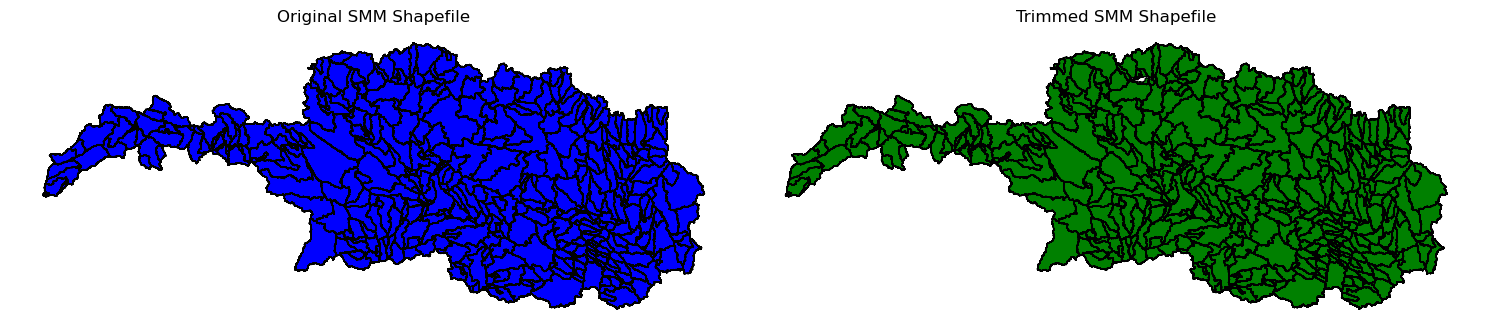

In [8]:
# Plotting to ensure trimming worked
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Plot the original shapefile
milk_shapefile.plot(ax=ax[0], color='blue', edgecolor='k')
ax[0].set_title('Original SMM Shapefile')
ax[0].set_axis_off()

# Plot the trimmed shapefile
trimmed_smm_gdf.plot(ax=ax[1], color='green', edgecolor='k')
ax[1].set_title('Trimmed SMM Shapefile')
ax[1].set_axis_off()

# Show the plot
plt.tight_layout()
plt.show()

In [9]:
def process_zonal_stats_from_gdf(raster_path, gdf):
    # Check CRS of the raster
    with rasterio.open(raster_path) as src:
        raster_crs = src.crs
        raster_epsg = raster_crs.to_string()  # Extract the EPSG code as a string
        print(f"Raster CRS EPSG: {raster_epsg}")

        # Plot the raster
        show(src)

        # Extract the transform and pixel size
        transform = src.transform
        pixel_width = transform[0]  # The pixel width is at position (0, 0)
        pixel_height = abs(transform[4])  # The pixel height is at position (1, 1)
        print(f'Pixel Height: {pixel_height}\nPixel Width: {pixel_width}')

    # Verify the initial CRS of the GeoDataFrame
    initial_epsg = gdf.crs.to_string()  # Extract the EPSG code as a string
    print(f'Initial CRS EPSG: {initial_epsg}')

    # Reproject the GeoDataFrame to match the raster's CRS
    gdf = gdf.to_crs(raster_crs)

    # Verify the reprojected CRS of the GeoDataFrame
    reprojected_epsg = gdf.crs.to_string()  # Extract the EPSG code as a string
    print(f'Reprojected CRS EPSG: {reprojected_epsg}')

    # Perform zonal statistics (mean, sum, etc.) between the reprojected GeoDataFrame and raster
    zonal_stats_results = zonal_stats(
        gdf,  # Reprojected shapefile (GeoDataFrame)
        raster_path,
        stats="count",
        geojson_out=True
    )

    # Convert the list of features into a GeoDataFrame
    zonal_stats_gdf = gpd.GeoDataFrame.from_features(zonal_stats_results)

    # Calculate NCA_Frac (NCA Fraction) using count and pixel area
    pixel_area = pixel_width * pixel_height
    zonal_stats_gdf['CA_Frac'] = (zonal_stats_gdf['count'] * pixel_area) / zonal_stats_gdf['Shape_Area']

    # Extract the decimal number from the raster filename using regex
    raster_filename = os.path.basename(raster_path)  # Get the filename from the path
    
    # Regex to extract the decimal number before '_mm'
    match = re.search(r'(\d+\.\d+)_mm', raster_filename)
    if match:
        decimal_number = match.group(1)  # Extracted decimal number (e.g., 1.000 or 22.400)
    else:
        raise ValueError(f"Could not find decimal number in filename: {raster_filename}")

    # Create the column name using the extracted decimal number
    column_name = f'NCAMapper_FCA_{decimal_number}mm'  # Example: NCAMapper_1.000

    # Rename the 'CA_Frac' column to the new name
    zonal_stats_gdf[column_name] = zonal_stats_gdf['CA_Frac']
    zonal_stats_gdf.drop('CA_Frac', axis=1, inplace=True)

    # Extract relevant columns ('seg_nhm' and the new column)
    subset_df = zonal_stats_gdf[['seg_nhm', column_name]]

    # Set 'seg_nhm' as the index
    subset_df.set_index('seg_nhm', inplace=True)

    # Convert the index to integer
    subset_df.index = subset_df.index.astype(int)

    return subset_df

Raster CRS EPSG: EPSG:26912


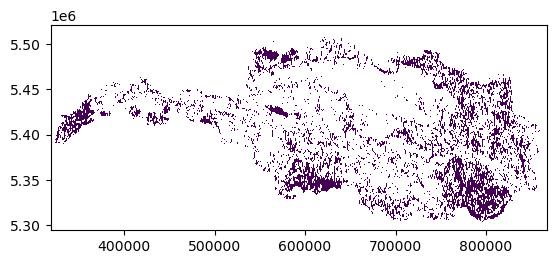

Pixel Height: 31.217319422283374
Pixel Width: 19.87737948875997
Initial CRS EPSG: EPSG:4326
Reprojected CRS EPSG: EPSG:26912


In [10]:
max_ca= process_zonal_stats_from_gdf(max_ca_path, trimmed_smm_gdf)

Raster CRS EPSG: EPSG:26912


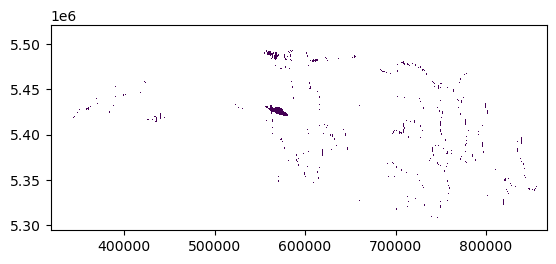

Pixel Height: 31.217319422283374
Pixel Width: 19.87737948875997
Initial CRS EPSG: EPSG:4326
Reprojected CRS EPSG: EPSG:26912


In [11]:
min_ca= process_zonal_stats_from_gdf(min_ca_path, trimmed_smm_gdf)

### Format HDS

In [12]:
# Parse the DATE column as datetime index
fca.index = pd.to_datetime(fca.index)
cilv.index = pd.to_datetime(cilv.index)
# Convert the column headers to integers
geodata.index = geodata.index.astype(int)

# Convert the column headers to integers
fca.columns = fca.columns.astype(int)
cilv.columns = cilv.columns.astype(int)

In [13]:
# Convert the values in the DataFrame to a list of integers
st_mary_list = st_mary[0].astype(int).tolist()

In [14]:
# Drop columns in `fca` that have headers found in `st_mary_list`
fca= fca.drop(columns=fca.columns[fca.columns.isin(st_mary_list)])

cilv= cilv.drop(columns=cilv.columns[cilv.columns.isin(st_mary_list)])

In [15]:
# find frac always contributing
geodata['frac_always_contributing']= 1 - geodata['icatch']

In [16]:
# find total basin area (m2)
milk_area= geodata['area'].sum()

In [17]:
# Replace any occurrence of -9999 with NaN
fca.replace(-9999, np.nan, inplace=True)
cilv.replace(-9999, np.nan, inplace=True)

In [18]:
# Filter rows where the date is between April 1st and September 30th
fca = fca[(fca.index.month >= 6) & (fca.index.month <= 9)]
cilv = cilv[(cilv.index.month >= 6) & (cilv.index.month <= 9)]

In [19]:
# Filter the DataFrame based on the year range
fca_filtered = fca[(fca.index.year >= barplot_min_year_range) & (fca.index.year <= barplot_max_year_range)].copy()
cilv_filtered = cilv[(cilv.index.year >= barplot_min_year_range) & (cilv.index.year <= barplot_max_year_range)].copy()

### icatch Validation

In [20]:
# Calculate the minimum of each column
min_con = fca_filtered.min(axis=0)

# Create a new DataFrame with the results
min_con = pd.DataFrame(min_con, columns=["Minimum_FCA"])

# Merge the 'icatch' column from df_max_per_year onto summary_df based on the index
min_con_merged = min_con.merge(geodata[['icatch']], left_index=True, right_index=True, how='left')

min_con_merged['Min_CA(1-icatch)']= 1 - min_con_merged['icatch']

min_con_merged['Difference (FCA Min -(1-icatch))']=  min_con_merged['Minimum_FCA'] - min_con_merged['Min_CA(1-icatch)']

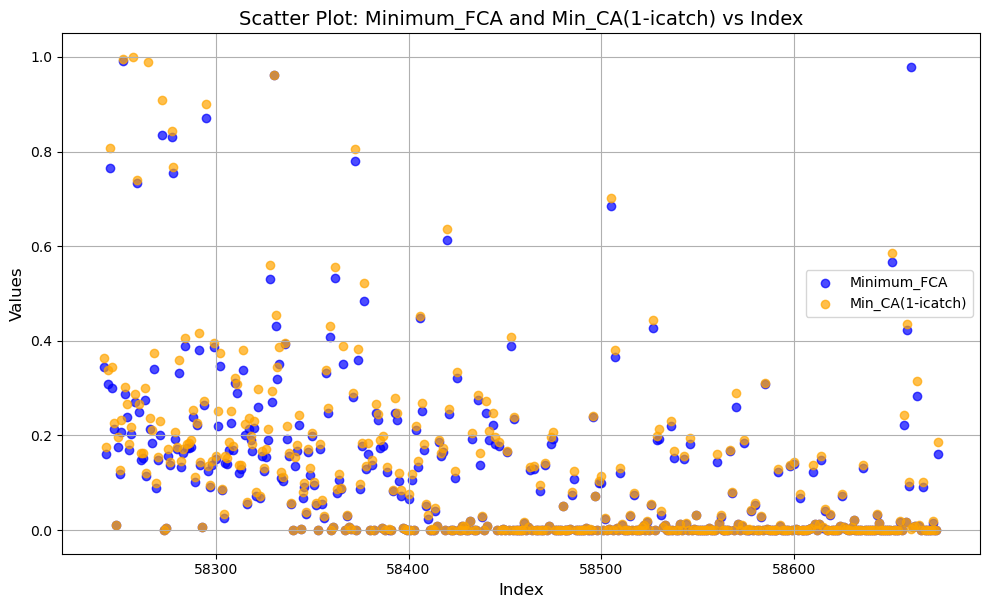

In [21]:
# Ensure the index is numeric
min_con_merged.index = pd.to_numeric(min_con_merged.index)

# Create the scatter plot
plt.figure(figsize=(10, 6.18))
plt.scatter(min_con_merged.index, min_con_merged['Minimum_FCA'], color='blue', label='Minimum_FCA', alpha=0.7)
plt.scatter(min_con_merged.index, min_con_merged['Min_CA(1-icatch)'], color='orange', label='Min_CA(1-icatch)', alpha=0.7)

# Add labels, title, legend, and grid
plt.xlabel('Index', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Scatter Plot: Minimum_FCA and Min_CA(1-icatch) vs Index', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('./outputs/min_fca_icatch.png')

# Show the plot
plt.show()

In [22]:
# Check where 'Min_CA(1-icatch)' is smaller than 'Minimum_FCA'
condition = min_con_merged['Min_CA(1-icatch)'] < min_con_merged['Minimum_FCA']

# Filter the rows where the condition is True
rows_with_smaller_values = min_con_merged[condition]

# Print results
if not rows_with_smaller_values.empty:
    print("There are rows where 'Min_CA(1-icatch)' is smaller than 'Minimum_FCA':")
else:
    print("No rows found where 'Min_CA(1-icatch)' is smaller than 'Minimum_FCA'.")

There are rows where 'Min_CA(1-icatch)' is smaller than 'Minimum_FCA':


In [23]:
rows_with_smaller_values

Minimum_FCA    icatch  Min_CA(1-icatch)  \
58661        0.979  0.998765          0.001235   
58508        0.004  0.996284          0.003716   
58557        0.001  0.999098          0.000902   
58630        0.007  0.993217          0.006783   
58449        0.002  0.998302          0.001698   
58596        0.001  0.999037          0.000963   
58613        0.012  0.988008          0.011992   
58624        0.008  0.992117          0.007883   
58487        0.001  0.999251          0.000749   
58627        0.003  0.997281          0.002719   
58462        0.007  0.993090          0.006910   
58556        0.005  0.995307          0.004693   
58503        0.001  0.999262          0.000738   
58586        0.002  0.998385          0.001615   
58473        0.009  0.991023          0.008977   

       Difference (FCA Min -(1-icatch))  
58661                          0.977765  
58508                          0.000284  
58557                          0.000098  
58630                          0.000217  
58449                          0.000302  
58596                          0.000037  
58613                          0.000008  
58624                          0.000117  
58487                          0.000251  
58627                          0.000281  
58462                          0.000090  
58556                          0.000307  
58503                          0.000262  
58586                          0.000385  
58473                          0.000023

### Find HDS Max CA

In [24]:
# Initialize a dictionary to store max/min values and their corresponding dates
max_min_values_and_dates = {}

# Iterate over each column
for column in fca_filtered.columns:
    if fca_filtered[column].notna().any():  # Check if the column has non-NaN values
        # Maximum value and corresponding date
        max_value = fca_filtered[column].max()
        max_date = fca_filtered[column].idxmax()
        
        # Minimum value and corresponding date
        min_value = fca_filtered[column].min()
        min_date = fca_filtered[column].idxmin()
        
        # Store in dictionary
        max_min_values_and_dates[column] = {
            'Max Value': max_value, 'Max Date': max_date,
            'Min Value': min_value, 'Min Date': min_date
        }
    else:
        max_min_values_and_dates[column] = {
            'Max Value': None, 'Max Date': None,
            'Min Value': None, 'Min Date': None
        }

# Convert the dictionary into a DataFrame for better visualization
max_min_values_df = pd.DataFrame(max_min_values_and_dates).T

In [25]:
# Initialize 'Max cilv' and 'Min cilv' columns in max_min_values_df
max_min_values_df['Max cilv'] = None
max_min_values_df['Min cilv'] = None

# Iterate through each row in max_min_values_df
for idx, row in max_min_values_df.iterrows():
    # Get the column name from the index (which is the same as the column in cilv)
    column_name = idx  # column_name in cilv corresponds to the index in max_min_values_df
    
    # Extract the Max Date and Min Date
    max_date = row['Max Date']
    min_date = row['Min Date']
    
    # If max_date and min_date are valid (not None), find the values in cilv
    if pd.notna(max_date):
        # Find the value corresponding to the Max Date in cilv
        if max_date in cilv.index:
            max_cilv_value = cilv.at[max_date, column_name]
            max_min_values_df.at[idx, 'Max cilv'] = max_cilv_value
    
    if pd.notna(min_date):
        # Find the value corresponding to the Min Date in cilv
        if min_date in cilv.index:
            min_cilv_value = cilv.at[min_date, column_name]
            max_min_values_df.at[idx, 'Min cilv'] = min_cilv_value

### Create Summary DataFrame

In [26]:
 #Create the summary DataFrame
summary_df = pd.DataFrame({
    'HDS_CA_Max': max_min_values_df['Max Value'],
    'HDS_CA_Min': max_min_values_df['Min Value'],
    'Max_CA_cilv': max_min_values_df['Max cilv'],
    'Min_CA_cilv': max_min_values_df['Min cilv']
})

In [27]:
# Merge NCAMapper results
merged_df = max_ca.merge(summary_df, left_index=True, right_index=True)

merged_df = min_ca.merge(merged_df, left_index=True, right_index=True)


In [28]:
# Merge the DataFrames on the index
merged_df = max_ca.merge(summary_df, left_index=True, right_index=True)

# Merge the DataFrames on the index
merged_df = min_ca.merge(merged_df, left_index=True, right_index=True)

In [29]:
merged_df = merged_df.merge(geodata[['frac_always_contributing', 'SLC_62','area','icatch']], left_index=True, right_index=True, how='left')

In [30]:
# Convert all columns in merged_df to numeric, forcing errors to NaN
merged_df = merged_df.apply(pd.to_numeric, errors='coerce')

In [31]:
# Replace zero values in the 'icatch' column with a very large number to account for divide by 0
merged_df['icatch'] = merged_df['icatch'].replace(0, 1e12)

# Find input precipitation required to fill depressions to this state
merged_df['P_input']= ((merged_df['Max_CA_cilv'] * 10**6) /(merged_df['area']*merged_df['icatch'])) * 1000 # convert m to mm

mean_P_depth= merged_df['P_input'].mean()
median_P_depth= merged_df['P_input'].median()
max_P_depth= merged_df['P_input'].max()

In [32]:
merged_df

NCAMapper_FCA_1.000mm  NCAMapper_FCA_22.400mm  HDS_CA_Max  \
seg_nhm                                                              
58242                 0.226624                0.687058       0.713   
58243                 0.170708                0.763736       0.770   
58244                 0.322041                0.531719       0.829   
58245                 0.767147                0.949782       0.964   
58246                 0.304195                0.376430       0.949   
...                        ...                     ...         ...   
58671                 0.000000                0.003167       0.112   
58672                 0.018485                0.053154       0.074   
58673                 0.000076                0.001495       0.051   
58674                 0.000000                0.020332       0.197   
58675                 0.188774                0.468550       0.245   

         HDS_CA_Min  Max_CA_cilv  Min_CA_cilv  frac_always_contributing  \
seg_nhm                                                                   
58242         0.344        2.611        0.106                  0.362830   
58243         0.161        6.142        0.267                  0.174972   
58244         0.309        1.072        0.038                  0.339217   
58245         0.765        0.023        0.005                  0.806693   
58246         0.300        0.178        0.012                  0.345393   
...             ...          ...          ...                       ...   
58671         0.000        8.825        0.602                  0.000000   
58672         0.015       32.566        1.027                  0.019354   
58673         0.000        5.529        0.283                  0.000000   
58674         0.000        1.468        0.122                  0.000000   
58675         0.161        4.547        0.382                  0.186841   

           SLC_62          area    icatch    P_input  
seg_nhm                                               
58242    0.053234  1.750165e+08  0.637170  23.413845  
58243    0.081200  2.952909e+08  0.825028  25.211057  
58244    0.089438  3.612230e+07  0.660783  44.911831  
58245    0.051981  7.746500e+06  0.193307  15.359397  
58246    0.131132  1.017080e+07  0.654607  26.735261  
...           ...           ...       ...        ...  
58671    0.264501  3.860121e+08  1.000000  22.861978  
58672    0.236104  9.586554e+08  0.980646  34.640937  
58673    0.287069  2.876408e+08  1.000000  19.221891  
58674    0.112770  2.727878e+08  1.000000   5.381472  
58675    0.140129  2.730521e+08  0.813159  20.478782  

[433 rows x 11 columns]

In [33]:
# Calculate statistics for P column
p_column = merged_df['P_input']

# Calculate the required statistics
statistics = {
    'Value (mm)': [
        p_column.min(),
        p_column.quantile(0.05),
        p_column.quantile(0.25),
        p_column.median(),
        p_column.quantile(0.75),
        p_column.quantile(0.95),
        p_column.max(),
    ]
}

# Create a DataFrame with 'Statistic' as the index
stats_df = pd.DataFrame(statistics, index=['Min', 'Q5', 'Q25', 'Q50 (Median)', 'Q75', 'Q95', 'Max'])

In [34]:
stats_df

Value (mm)
Min             0.000000
Q5              3.526378
Q25             8.041680
Q50 (Median)   13.725900
Q75            23.196780
Q95            46.789873
Max           194.874347

C:\Users\Paul Coderre\AppData\Local\Temp\ipykernel_33516\2744375121.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


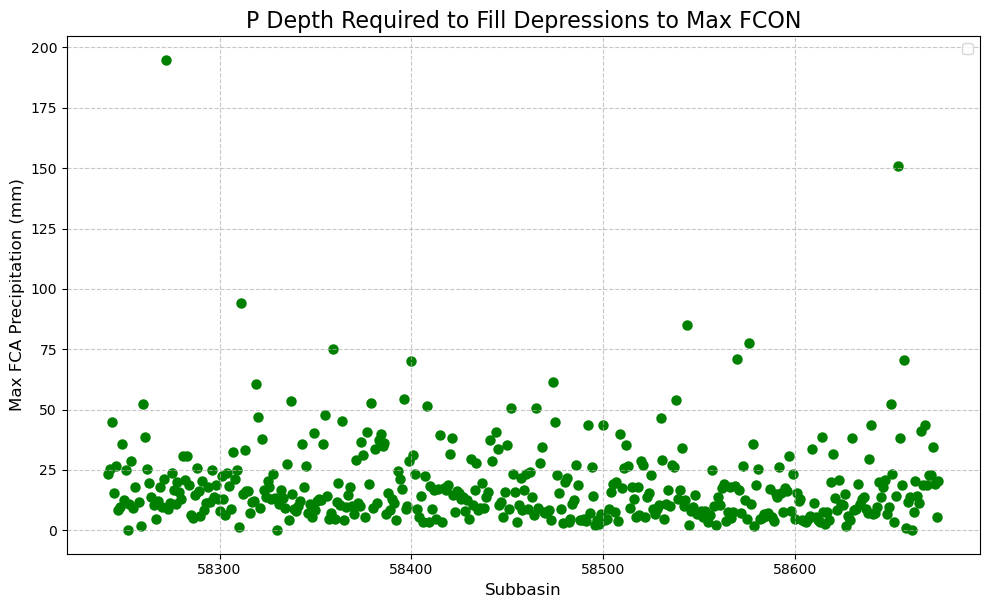

In [35]:
plt.figure(figsize=(10, 6.18))
plt.scatter(merged_df.index, merged_df['P_input'],  color='green', linewidth=1.5)
plt.title('P Depth Required to Fill Depressions to Max FCON', fontsize=16)
plt.xlabel('Subbasin', fontsize=12)
plt.ylabel('Max FCA Precipitation (mm)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('./outputs/max_fca_P.png')

# Show the plot
plt.show()

### Plot CA Comparison

In [40]:
# Add a column for 'area' * 'SLC_62'
merged_df['depression_area'] = merged_df['area'] * merged_df['SLC_62']

# Sort the DataFrame by 'area' and 'area * SLC_62'
df_sorted = merged_df.sort_values(by=['area', 'depression_area', 'P_input'], ascending=[False, False, False])

# Drop rows with missing values
df_sorted_clean = df_sorted.dropna(subset=['area', 'depression_area', 'P_input']).copy()

# Prepare the data for clustering
clustering_data_multi_clean = df_sorted_clean[['area', 'depression_area', 'P_input']].to_numpy()

# Initialize the scaler
scaler = StandardScaler()

# Standardize the data for better clustering
clustering_data_multi_scaled = scaler.fit_transform(clustering_data_multi_clean)

# Set environment variable to avoid memory leak on Windows
os.environ["OMP_NUM_THREADS"] = "2"

# Apply KMeans clustering
kmeans_multi = KMeans(n_clusters=num_clusters, random_state=42)
df_sorted_clean['Cluster_Multi'] = kmeans_multi.fit_predict(clustering_data_multi_scaled)


C:\Users\Paul Coderre\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


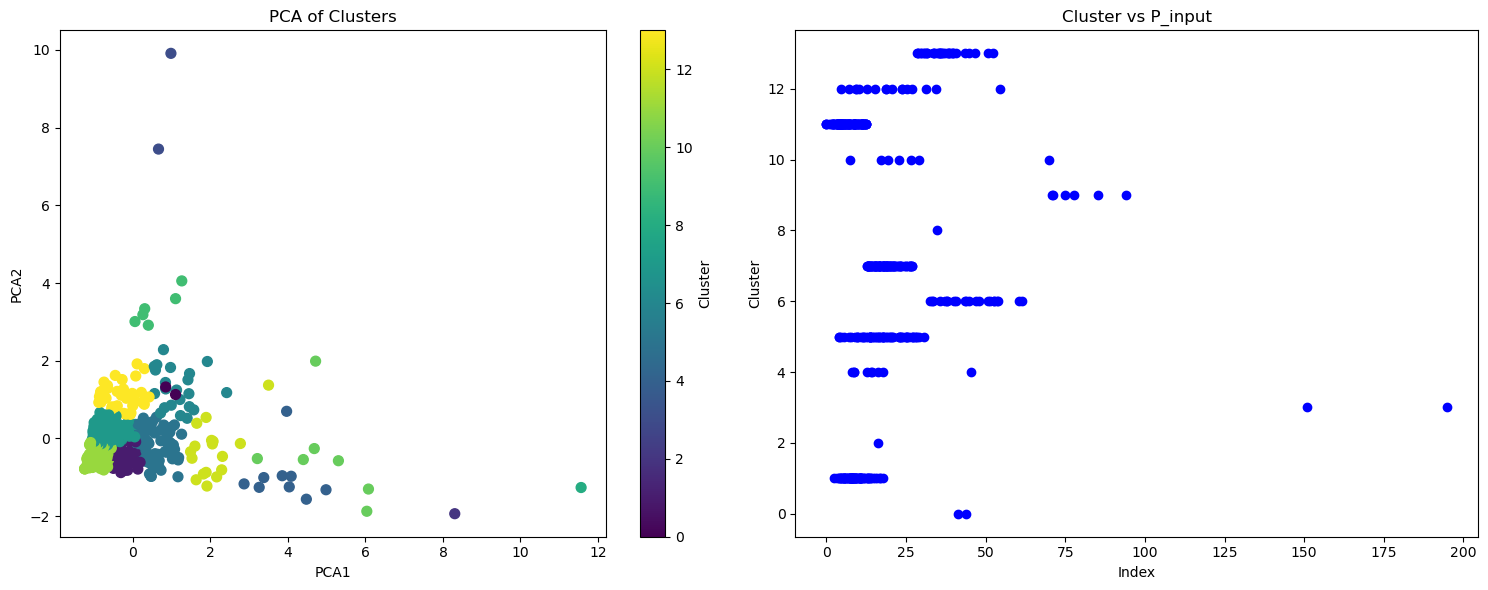

In [41]:
# Reduce the dimensions of the data to 2D using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(clustering_data_multi_scaled)

# Add the cluster labels to the reduced data
df_sorted_clean['PCA1'] = reduced_data[:, 0]
df_sorted_clean['PCA2'] = reduced_data[:, 1]


# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. PCA Plot (First subplot)
scatter = axes[0].scatter(df_sorted_clean['PCA1'], df_sorted_clean['PCA2'], c=df_sorted_clean['Cluster_Multi'], cmap='viridis', s=50)
axes[0].set_xlabel('PCA1')
axes[0].set_ylabel('PCA2')
axes[0].set_title('PCA of Clusters')

# Add a color bar to indicate cluster labels
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Cluster')

# 2. Cluster vs Index Plot (Second subplot)
axes[1].scatter(df_sorted_clean['P_input'], df_sorted_clean['Cluster_Multi'], marker='o', linestyle='-', color='b')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Cluster')
axes[1].set_title('Cluster vs P_input')

# Adjust layout to avoid overlap between subplots
plt.tight_layout()

# Show the plots
plt.show()

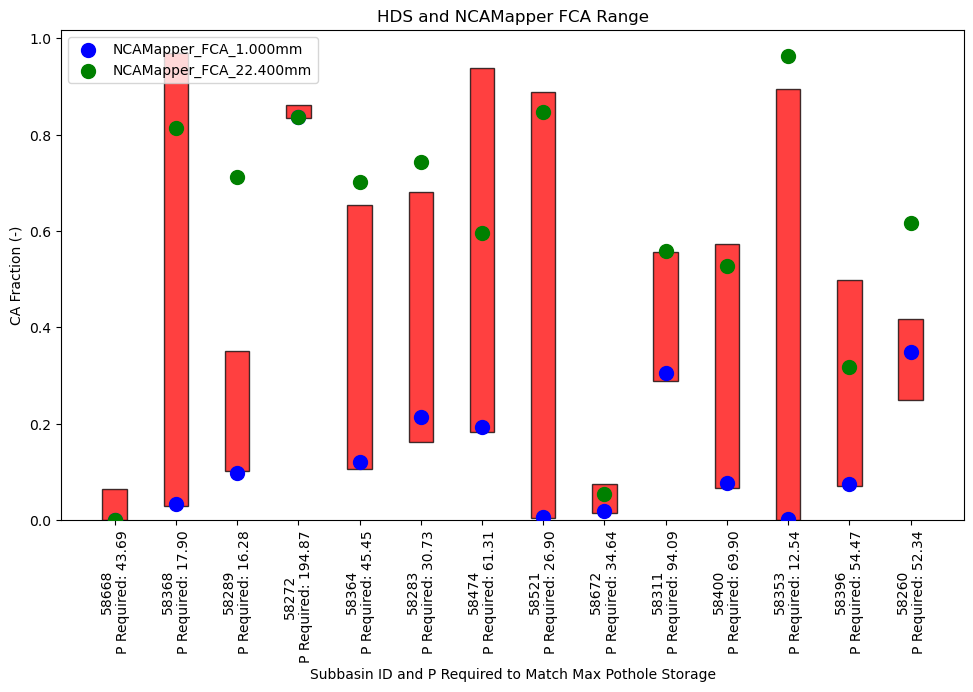

Plot of CA Fraction Ranges by Cluster with NCAMapper Dots saved.


In [43]:
# Sort the df_sorted_clean by its index
df_sorted_clean_sorted = df_sorted_clean.sort_index()

# Group by the 'Cluster_Multi' column and select the row with the highest 'P_input' value in each group
highest_p_input_rows = df_sorted_clean_sorted.loc[df_sorted_clean_sorted.groupby('Cluster_Multi')['P_input'].idxmax()]

# Define the colors and transparency for the bars
bar_colors = {'HDS CA': 'red'}
alpha_value = 0.75  # Transparency for the bars

# Manually define the list of colors for the NCAMapper columns (ensure it has enough colors)
ncamapper_columns = [col for col in df_sorted_clean_sorted.columns if 'NCAMapper' in col]

# Manually define a list of colors (you can add as many as needed)
ncamapper_colors = ['blue', 'green', 'orange', 'purple', 'brown']  # Add more colors as needed

# Create a figure for the combined plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set the positions for the bars based on the number of unique clusters
unique_clusters = highest_p_input_rows['Cluster_Multi'].unique()
x_positions = np.arange(len(unique_clusters))

# Loop through each unique cluster and plot a bar for the row with the highest 'P_input'
for idx, cluster in enumerate(unique_clusters):
    # Filter the row corresponding to the current cluster with the highest 'P_input'
    cluster_row = highest_p_input_rows[highest_p_input_rows['Cluster_Multi'] == cluster].iloc[0]

    # Bar for HDS CA range
    ax.bar(x_positions[idx], 
           cluster_row['HDS_CA_Max'] - cluster_row['HDS_CA_Min'], 
           width=0.4, 
           bottom=cluster_row['HDS_CA_Min'], 
           color=bar_colors['HDS CA'], 
           alpha=alpha_value, 
           label=f'Cluster {cluster} HDS Range',
           edgecolor='black')

    # Plot dots for columns with "NCAMapper" in the name
    for i, ncamapper_column in enumerate(ncamapper_columns):
        # Get the corresponding color from the manually defined color list
        dot_color = ncamapper_colors[i % len(ncamapper_colors)]  # Use modulus to loop through colors
        
        # Place dots vertically at the same x position (no horizontal shift)
        ax.scatter(x_positions[idx], 
                   cluster_row[ncamapper_column], 
                   color=dot_color, 
                   s=100,  # Size of the dots
                   label=f'{ncamapper_column}' if idx == 0 else "",  # Only add label once
                   zorder=5)

    # Add P_input value to x-axis label
    x_label = f'Subbasin: {cluster_row.name}\nP Required: {cluster_row["P_input"]:.2f}'  # Combine idx and P_input value
    ax.set_xticks(x_positions)
    ax.set_xticklabels([f'{highest_p_input_rows.iloc[i].name}\nP Required: {highest_p_input_rows.iloc[i]["P_input"]:.2f}' 
                        for i in range(len(highest_p_input_rows))])

# Set labels for axes and title
ax.set_xlabel('Subbasin ID and P Required to Match Max Pothole Storage')
ax.set_ylabel('CA Fraction (-)')
ax.set_title('HDS and NCAMapper FCA Range')

# Adjust layout to ensure labels don't overlap
plt.tight_layout()

# Rotate x-axis labels by 45 degrees for better readability
plt.xticks(rotation=90)

# Add a legend (we'll use only the first label for each cluster to avoid duplicate entries)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[handles[0], handles[1]], labels=[labels[0], labels[1]], loc='upper left')

# Save the plot
plot_filename = os.path.join(barplot_output_dir, 'highest_p_input_cluster_bar_with_ncamapper_dots_colored.png')
plt.savefig(plot_filename)
plt.show()

# Optionally, display a message indicating completion
print("Plot of CA Fraction Ranges by Cluster with NCAMapper Dots saved.")

In [53]:
# Get the total number of rows in merged_df
total_rows = len(merged_df)

# Initialize an empty list to store the results for each row
comparison_results = []

# Get the smaller length between `stats_df` and `ncamapper_columns` to avoid index errors
min_len = min(len(stats_df), len(ncamapper_columns))

# Iterate through the smaller length to avoid going out of bounds
for i in range(min_len):
    # Get the corresponding index (row name) from stats_df
    stat_index = stats_df.index[i]
    stat_value = stats_df['Value (mm)'].iloc[i]  # Using iloc to avoid FutureWarning

    # Loop through each NCAMapper column
    ncamapper_col = ncamapper_columns[i]

    # Count rows where NCAMapper value is within the range (HDS_CA_Min <= NCAMapper <= HDS_CA_Max)
    within_range = ((merged_df[ncamapper_col] >= merged_df['HDS_CA_Min']) & 
                    (merged_df[ncamapper_col] <= merged_df['HDS_CA_Max'])).sum()
    
    # Count rows where NCAMapper value is greater than HDS_CA_Max
    greater_than_max = (merged_df[ncamapper_col] > merged_df['HDS_CA_Max']).sum()
    
    # Count rows where NCAMapper value is smaller than HDS_CA_Min
    smaller_than_min = (merged_df[ncamapper_col] < merged_df['HDS_CA_Min']).sum()
    
    # Calculate percentages
    within_range_percentage = (within_range / total_rows) * 100
    greater_than_max_percentage = (greater_than_max / total_rows) * 100
    smaller_than_min_percentage = (smaller_than_min / total_rows) * 100

    # Add the result as a new row in the list for DataFrame
    comparison_results.append({
        'NCAMapper_Column': f"{ncamapper_col} Corresponding to {stat_index}",
        'within_range': within_range_percentage,
        'smaller_than_min': smaller_than_min_percentage,
        'greater_than_max': greater_than_max_percentage
    })

# Create a DataFrame from the results list
comparison_df = pd.DataFrame(comparison_results)

# Set the 'NCAMapper_Column' as the index
comparison_df.set_index('NCAMapper_Column', inplace=True)

# Print the DataFrame to verify
print(comparison_df)

                                            within_range  smaller_than_min  \
NCAMapper_Column                                                             
NCAMapper_FCA_1.000mm Corresponding to Min     86.374134         12.702079   
NCAMapper_FCA_22.400mm Corresponding to Q5     56.351039          1.154734   

                                            greater_than_max  
NCAMapper_Column                                              
NCAMapper_FCA_1.000mm Corresponding to Min          0.461894  
NCAMapper_FCA_22.400mm Corresponding to Q5         42.032333  


In [54]:
comparison_df

within_range  smaller_than_min  \
NCAMapper_Column                                                             
NCAMapper_FCA_1.000mm Corresponding to Min     86.374134         12.702079   
NCAMapper_FCA_22.400mm Corresponding to Q5     56.351039          1.154734   

                                            greater_than_max  
NCAMapper_Column                                              
NCAMapper_FCA_1.000mm Corresponding to Min          0.461894  
NCAMapper_FCA_22.400mm Corresponding to Q5         42.032333